In [1]:
# Import libraries

!mkdir utils
!curl https://raw.githubusercontent.com/jgenc/vit-research/main/utils/patchifying.py > ./utils/patchifying.py
!curl https://raw.githubusercontent.com/jgenc/vit-research/main/utils/train_loop.py > ./utils/train_loop.py
!curl https://raw.githubusercontent.com/jgenc/vit-research/main/utils/plotting.py > ./utils/plotting.py
!curl https://raw.githubusercontent.com/jgenc/vit-research/main/test.png> image.png
%pip install torchinfo

from utils.train_loop import train_loop
from utils.plotting import plot_results
from torchvision.models import VisionTransformer
from torchvision.datasets.cifar import CIFAR10, CIFAR100
from torchvision.datasets.mnist import FashionMNIST
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Grayscale, Compose
import torch
from torchinfo import summary

from torch.utils.tensorboard import SummaryWriter
from matplotlib import pyplot as plt


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   337  100   337    0     0   1407      0 --:--:-- --:--:-- --:--:--  1410
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2825  100  2825    0     0  16394      0 --:--:-- --:--:-- --:--:-- 16424
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2974  100  2974    0     0  17751      0 --:--:-- --:--:-- --:--:-- 17808
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   797  100   797    0     0   4529      0 --:--:-- --:--:-- --:--:--  4554


In [2]:
# # Import CIFAR-10 dataset

# train_dataset = CIFAR10(root='./data', train=True, download=True, transform=ToTensor())
# test_dataset = CIFAR10(root='./data', train=False, download=True, transform=ToTensor())

# train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [3]:
# Import FashionMNIST dataset

transforms = Compose([
    Grayscale(3),
    ToTensor(),
])

train_dataset = FashionMNIST(root='./data', train=True, download=True, transform=transforms)    # Το καινούριο train set
test_dataset = FashionMNIST(root='./data', train=False, download=True, transform=transforms)    # Το καινούριο test set

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)                          # Αυτά μένουν ίδια
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

100%|██████████| 26421880/26421880 [00:01<00:00, 16048872.56it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 271889.63it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5122504.22it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 19261620.87it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Define function that prints a title

In [31]:
def title(txt, lenth=100):
    print(lenth * '=', f' {txt} '.center(lenth, '='), lenth * '=', '\n', sep='\n')

Define a function that from given parameters, defines and trains a model, prints summary, plots metrics and returns the model

In [21]:
def model_from_params(**kwargs):
    # Define ViT parameters
    num_layers = kwargs['num_layers']
    num_heads = kwargs['num_heads']
    num_classes = kwargs['num_classes']
    hidden_dim = kwargs['hidden_dim']
    mlp_dim = kwargs['mlp_dim']
    dropout = kwargs['dropout']
    patch_size = kwargs['patch_size']
    image_size = kwargs['image_size']
    N_EPOCHS = kwargs['N_EPOCHS']
    LR = kwargs['LR']

    #define ViT model
    model = VisionTransformer(
            image_size=image_size,
            patch_size=patch_size,
            num_layers=num_layers,
            hidden_dim=hidden_dim,
            num_heads=num_heads,
            num_classes=num_classes,
            mlp_dim=mlp_dim,
            dropout=dropout,
        ).to(device)

    # Estimate ViT model size
    # input_size = (128, 3, 32, 32) # CIFAR-10
    input_size = (128, 3, 28, 28) # FashionMNIST
    title('SUMMARY')
    print(summary(model, input_size=input_size))

    title('TRAINING MODEL')
    # Train ViT model
    metrics = train_loop(
        model,
        train_loader,
        test_loader,
        device,
        num_layers,
        num_heads,
        hidden_dim,
        mlp_dim,
        N_EPOCHS,
        LR,
        # writer=SummaryWriter('runs/vit_cifar10'),
    )
    train_loss_metric, train_accuracy_metric, test_loss_metric, test_accuracy_metric = metrics

    title('PLOT RESULTS')
    # Plot training performance metrics
    plot_results(
        num_layers,
        num_heads,
        hidden_dim,
        N_EPOCHS,
        LR,
        test_accuracy_metric,
        train_accuracy_metric,
        test_loss_metric,
        train_loss_metric,
    )

    return model

## Model with predefined parameters (1)

============================================= SUMMARY ==============================================


Layer (type:depth-idx)                        Output Shape              Param #
VisionTransformer                             [128, 10]                 128
├─Conv2d: 1-1                                 [128, 128, 7, 7]          6,272
├─Encoder: 1-2                                [128, 50, 128]            6,400
│    └─Dropout: 2-1                           [128, 50, 128]            --
│    └─Sequential: 2-2                        [128, 50, 128]            --
│    │    └─EncoderBlock: 3-1                 [128, 50, 128]            99,584
│    │    └─EncoderBlock: 3-2                 [128, 50, 128]            99,584
│    │    └─EncoderBlock: 3-3                 [128, 50, 128]            99,584
│    │    └─EncoderBlock: 3-4                 [128, 50, 128]            99,584
│    │    └─EncoderBlock: 3-5                 [128, 50, 128]            99,584
│    │    └─EncoderBlock: 3-6           

Epoch 1 in training: 100%|██████████| 469/469 [00:27<00:00, 18.53it/s]
                                                                      

Epoch 1/10 
Train loss: 1.64, Train accuracy: 47.87%



Training:  10%|█         | 1/10 [00:30<04:36, 30.75s/it]

Test loss: 1.28
Test accuracy: 55.13%



Epoch 2 in training: 100%|█████████▉| 468/469 [00:27<00:00, 17.35it/s]
                                                                      

Epoch 2/10 
Train loss: 1.04, Train accuracy: 61.85%



Training:  20%|██        | 2/10 [01:02<04:09, 31.14s/it]

Test loss: 0.90
Test accuracy: 66.01%



Epoch 3 in training: 100%|█████████▉| 468/469 [00:30<00:00, 17.61it/s]
                                                                      

Epoch 3/10 
Train loss: 0.81, Train accuracy: 70.19%



Training:  30%|███       | 3/10 [01:36<03:49, 32.77s/it]

Test loss: 0.77
Test accuracy: 72.78%



Epoch 4 in training: 100%|█████████▉| 468/469 [00:35<00:00, 16.34it/s]
                                                                      

Epoch 4/10 
Train loss: 0.67, Train accuracy: 77.21%



Training:  40%|████      | 4/10 [02:15<03:31, 35.21s/it]

Test loss: 0.63
Test accuracy: 78.30%



Epoch 5 in training: 100%|█████████▉| 468/469 [00:31<00:00, 13.91it/s]
                                                                      

Epoch 5/10 
Train loss: 0.57, Train accuracy: 79.86%



Training:  50%|█████     | 5/10 [02:50<02:55, 35.05s/it]

Test loss: 0.56
Test accuracy: 80.54%



Epoch 6 in training: 100%|██████████| 469/469 [00:29<00:00, 14.26it/s]
                                                                      

Epoch 6/10 
Train loss: 0.53, Train accuracy: 81.40%



Training:  60%|██████    | 6/10 [03:23<02:16, 34.19s/it]

Test loss: 0.54
Test accuracy: 80.73%



Epoch 7 in training: 100%|█████████▉| 468/469 [00:28<00:00, 17.04it/s]
                                                                      

Epoch 7/10 
Train loss: 0.50, Train accuracy: 82.08%



Training:  70%|███████   | 7/10 [03:55<01:40, 33.54s/it]

Test loss: 0.51
Test accuracy: 81.62%



Epoch 8 in training: 100%|██████████| 469/469 [00:34<00:00, 15.27it/s]
                                                                      

Epoch 8/10 
Train loss: 0.48, Train accuracy: 82.62%



Training:  80%|████████  | 8/10 [04:33<01:10, 35.09s/it]

Test loss: 0.50
Test accuracy: 81.82%



Epoch 9 in training: 100%|█████████▉| 468/469 [00:31<00:00, 16.84it/s]
                                                                      

Epoch 9/10 
Train loss: 0.46, Train accuracy: 83.18%



Training:  90%|█████████ | 9/10 [05:08<00:34, 34.89s/it]

Test loss: 0.49
Test accuracy: 81.83%



Epoch 10 in training: 100%|█████████▉| 468/469 [00:30<00:00, 17.02it/s]
                                                                       

Epoch 10/10 
Train loss: 0.45, Train accuracy: 83.62%



Training: 100%|██████████| 10/10 [05:41<00:00, 34.19s/it]


Test loss: 0.47
Test accuracy: 82.86%
============================================= SUMMARY ==============================================




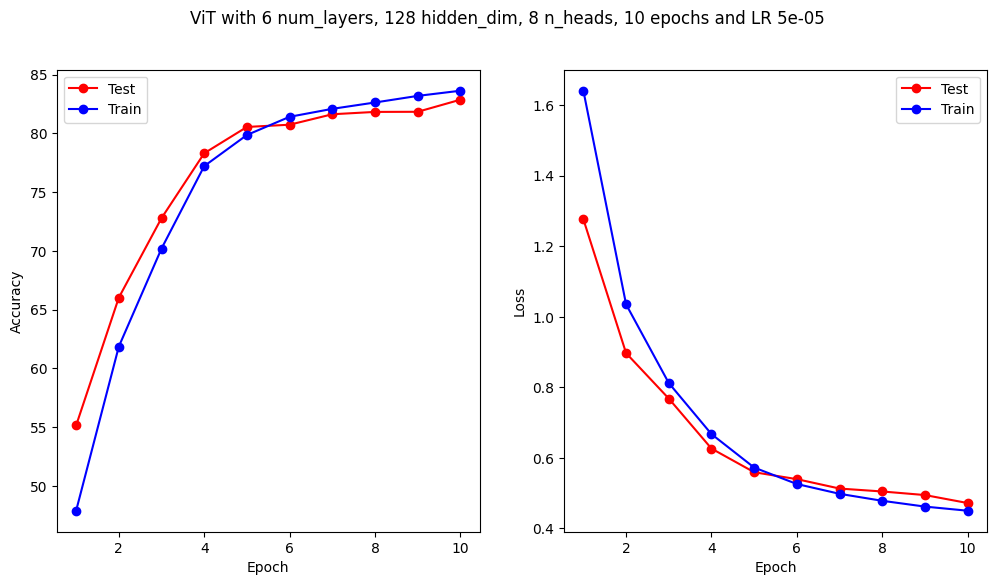

In [22]:
# Define ViT parameters
param_dict = dict(
    num_layers=6,
    num_heads=8,
    num_classes=10,
    hidden_dim=128,
    mlp_dim=128,
    dropout=0.1,
    patch_size=4,
    image_size=train_dataset[0][0].shape[1],
    N_EPOCHS=10,
    LR=5e-5,
)


model_1 = model_from_params(**param_dict)

## Define new parameters (2)

============================================= SUMMARY ==============================================


Layer (type:depth-idx)                        Output Shape              Param #
VisionTransformer                             [128, 10]                 128
├─Conv2d: 1-1                                 [128, 128, 7, 7]          6,272
├─Encoder: 1-2                                [128, 50, 128]            6,400
│    └─Dropout: 2-1                           [128, 50, 128]            --
│    └─Sequential: 2-2                        [128, 50, 128]            --
│    │    └─EncoderBlock: 3-1                 [128, 50, 128]            99,584
│    │    └─EncoderBlock: 3-2                 [128, 50, 128]            99,584
│    │    └─EncoderBlock: 3-3                 [128, 50, 128]            99,584
│    │    └─EncoderBlock: 3-4                 [128, 50, 128]            99,584
│    │    └─EncoderBlock: 3-5                 [128, 50, 128]            99,584
│    │    └─EncoderBlock: 3-6           

Epoch 1 in training: 100%|█████████▉| 468/469 [00:35<00:00, 13.81it/s]
                                                                      

Epoch 1/13 
Train loss: 1.63, Train accuracy: 49.71%



Training:   8%|▊         | 1/13 [00:39<07:53, 39.43s/it]

Test loss: 1.21
Test accuracy: 57.68%



Epoch 2 in training: 100%|██████████| 469/469 [00:37<00:00, 14.39it/s]
                                                                      

Epoch 2/13 
Train loss: 1.00, Train accuracy: 63.92%



Training:  15%|█▌        | 2/13 [01:20<07:22, 40.22s/it]

Test loss: 0.86
Test accuracy: 68.36%



Epoch 3 in training: 100%|██████████| 469/469 [00:39<00:00, 14.09it/s]
                                                                      

Epoch 3/13 
Train loss: 0.76, Train accuracy: 73.23%



Training:  23%|██▎       | 3/13 [02:03<06:56, 41.63s/it]

Test loss: 0.68
Test accuracy: 76.60%



Epoch 4 in training: 100%|█████████▉| 468/469 [00:40<00:00, 13.61it/s]
                                                                      

Epoch 4/13 
Train loss: 0.61, Train accuracy: 78.82%



Training:  31%|███       | 4/13 [02:47<06:21, 42.40s/it]

Test loss: 0.60
Test accuracy: 79.19%



Epoch 5 in training: 100%|██████████| 469/469 [00:38<00:00, 13.72it/s]
                                                                      

Epoch 5/13 
Train loss: 0.55, Train accuracy: 80.41%



Training:  38%|███▊      | 5/13 [03:30<05:41, 42.68s/it]

Test loss: 0.55
Test accuracy: 80.62%



Epoch 6 in training: 100%|██████████| 469/469 [00:36<00:00, 13.74it/s]
                                                                      

Epoch 6/13 
Train loss: 0.52, Train accuracy: 81.48%



Training:  46%|████▌     | 6/13 [04:10<04:52, 41.78s/it]

Test loss: 0.53
Test accuracy: 80.89%



Epoch 7 in training: 100%|██████████| 469/469 [00:35<00:00, 14.09it/s]
                                                                      

Epoch 7/13 
Train loss: 0.49, Train accuracy: 82.32%



Training:  54%|█████▍    | 7/13 [04:49<04:05, 40.91s/it]

Test loss: 0.51
Test accuracy: 81.38%



Epoch 8 in training: 100%|█████████▉| 468/469 [00:35<00:00, 13.24it/s]
                                                                      

Epoch 8/13 
Train loss: 0.47, Train accuracy: 82.89%



Training:  62%|██████▏   | 8/13 [05:28<03:22, 40.48s/it]

Test loss: 0.50
Test accuracy: 81.98%



Epoch 9 in training: 100%|█████████▉| 468/469 [00:35<00:00, 11.95it/s]
                                                                      

Epoch 9/13 
Train loss: 0.46, Train accuracy: 83.38%



Training:  69%|██████▉   | 9/13 [06:09<02:41, 40.37s/it]

Test loss: 0.49
Test accuracy: 82.08%



Epoch 10 in training: 100%|██████████| 469/469 [00:39<00:00,  9.91it/s]
                                                                       

Epoch 10/13 
Train loss: 0.45, Train accuracy: 83.69%



Training:  77%|███████▋  | 10/13 [06:53<02:04, 41.49s/it]

Test loss: 0.48
Test accuracy: 82.36%



Epoch 11 in training: 100%|█████████▉| 468/469 [00:43<00:00, 13.31it/s]
                                                                       

Epoch 11/13 
Train loss: 0.44, Train accuracy: 84.03%



Training:  85%|████████▍ | 11/13 [07:41<01:27, 43.59s/it]

Test loss: 0.47
Test accuracy: 82.60%



Epoch 12 in training: 100%|█████████▉| 468/469 [00:43<00:00, 13.02it/s]
                                                                       

Epoch 12/13 
Train loss: 0.42, Train accuracy: 84.45%



Training:  92%|█████████▏| 12/13 [08:28<00:44, 44.58s/it]

Test loss: 0.45
Test accuracy: 83.47%



Epoch 13 in training: 100%|█████████▉| 468/469 [00:39<00:00, 13.18it/s]
                                                                       

Epoch 13/13 
Train loss: 0.41, Train accuracy: 84.80%



Training: 100%|██████████| 13/13 [09:11<00:00, 42.42s/it]


Test loss: 0.45
Test accuracy: 83.44%
============================================= SUMMARY ==============================================




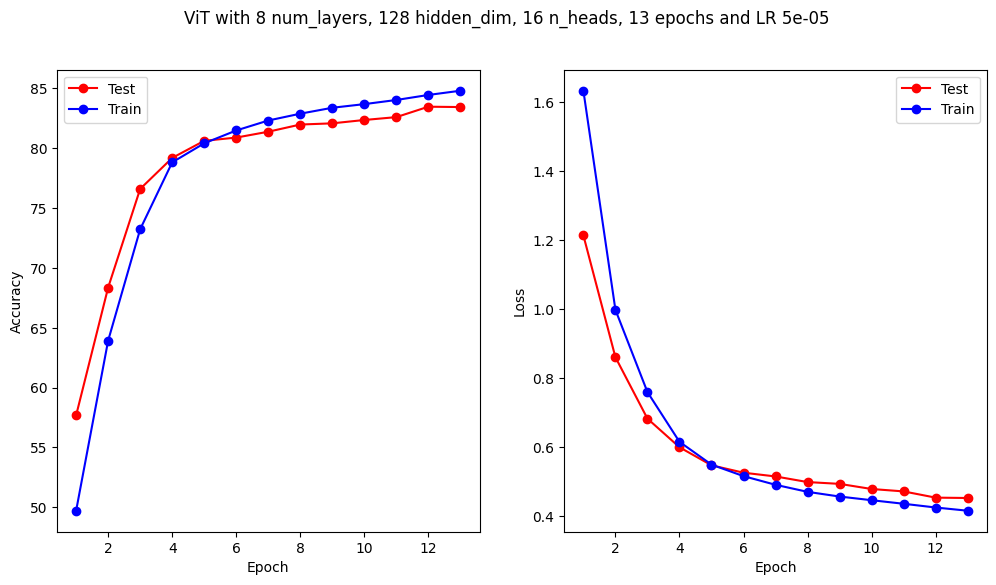

In [24]:
# Define ViT parameters
param_dict = dict(
    num_layers=8,
    num_heads=16,
    num_classes=10,
    hidden_dim=128,
    mlp_dim=128,
    dropout=0.1,
    patch_size=4,
    image_size=train_dataset[0][0].shape[1],
    N_EPOCHS=13,
    LR=5e-5,
)


model_2 = model_from_params(**param_dict)

## Define new parameters (3)

============================================= SUMMARY ==============================================


Layer (type:depth-idx)                        Output Shape              Param #
VisionTransformer                             [128, 10]                 128
├─Conv2d: 1-1                                 [128, 128, 7, 7]          6,272
├─Encoder: 1-2                                [128, 50, 128]            6,400
│    └─Dropout: 2-1                           [128, 50, 128]            --
│    └─Sequential: 2-2                        [128, 50, 128]            --
│    │    └─EncoderBlock: 3-1                 [128, 50, 128]            99,584
│    │    └─EncoderBlock: 3-2                 [128, 50, 128]            99,584
│    │    └─EncoderBlock: 3-3                 [128, 50, 128]            99,584
│    │    └─EncoderBlock: 3-4                 [128, 50, 128]            99,584
│    │    └─EncoderBlock: 3-5                 [128, 50, 128]            99,584
│    │    └─EncoderBlock: 3-6           

Epoch 1 in training: 100%|█████████▉| 468/469 [00:50<00:00,  9.37it/s]
                                                                      

Epoch 1/16 
Train loss: 1.66, Train accuracy: 47.12%



Training:   6%|▋         | 1/16 [00:54<13:44, 54.98s/it]

Test loss: 1.27
Test accuracy: 55.46%



Epoch 2 in training: 100%|█████████▉| 468/469 [00:50<00:00,  9.40it/s]
                                                                      

Epoch 2/16 
Train loss: 1.05, Train accuracy: 61.38%



Training:  12%|█▎        | 2/16 [01:49<12:44, 54.63s/it]

Test loss: 0.90
Test accuracy: 64.66%



Epoch 3 in training: 100%|█████████▉| 468/469 [00:51<00:00,  8.47it/s]
                                                                      

Epoch 3/16 
Train loss: 0.81, Train accuracy: 69.46%



Training:  19%|█▉        | 3/16 [02:44<11:56, 55.08s/it]

Test loss: 0.75
Test accuracy: 73.30%



Epoch 4 in training: 100%|█████████▉| 468/469 [00:51<00:00,  9.03it/s]
                                                                      

Epoch 4/16 
Train loss: 0.67, Train accuracy: 76.70%



Training:  25%|██▌       | 4/16 [03:40<11:04, 55.36s/it]

Test loss: 0.63
Test accuracy: 77.72%



Epoch 5 in training: 100%|█████████▉| 468/469 [00:52<00:00,  8.85it/s]
                                                                      

Epoch 5/16 
Train loss: 0.57, Train accuracy: 79.80%



Training:  31%|███▏      | 5/16 [04:37<10:13, 55.78s/it]

Test loss: 0.57
Test accuracy: 80.09%



Epoch 6 in training: 100%|█████████▉| 468/469 [00:52<00:00,  9.03it/s]
                                                                      

Epoch 6/16 
Train loss: 0.53, Train accuracy: 81.19%



Training:  38%|███▊      | 6/16 [05:34<09:23, 56.34s/it]

Test loss: 0.53
Test accuracy: 81.02%



Epoch 7 in training: 100%|█████████▉| 468/469 [00:53<00:00,  8.57it/s]
                                                                      

Epoch 7/16 
Train loss: 0.49, Train accuracy: 82.19%



Training:  44%|████▍     | 7/16 [06:32<08:32, 56.89s/it]

Test loss: 0.51
Test accuracy: 81.38%



Epoch 8 in training: 100%|█████████▉| 468/469 [00:53<00:00,  8.87it/s]
                                                                      

Epoch 8/16 
Train loss: 0.48, Train accuracy: 82.69%



Training:  50%|█████     | 8/16 [07:30<07:38, 57.25s/it]

Test loss: 0.50
Test accuracy: 82.03%



Epoch 9 in training: 100%|█████████▉| 468/469 [00:54<00:00,  8.49it/s]
                                                                      

Epoch 9/16 
Train loss: 0.46, Train accuracy: 83.35%



Training:  56%|█████▋    | 9/16 [08:29<06:43, 57.67s/it]

Test loss: 0.49
Test accuracy: 82.07%



Epoch 10 in training: 100%|█████████▉| 468/469 [00:54<00:00,  8.70it/s]
                                                                       

Epoch 10/16 
Train loss: 0.45, Train accuracy: 83.68%



Training:  62%|██████▎   | 10/16 [09:28<05:48, 58.16s/it]

Test loss: 0.47
Test accuracy: 82.52%



Epoch 11 in training: 100%|█████████▉| 468/469 [00:55<00:00,  8.35it/s]
                                                                       

Epoch 11/16 
Train loss: 0.43, Train accuracy: 84.14%



Training:  69%|██████▉   | 11/16 [10:29<04:54, 58.93s/it]

Test loss: 0.48
Test accuracy: 82.74%



Epoch 12 in training: 100%|█████████▉| 468/469 [00:54<00:00,  8.63it/s]
                                                                       

Epoch 12/16 
Train loss: 0.42, Train accuracy: 84.41%



Training:  75%|███████▌  | 12/16 [11:28<03:55, 58.99s/it]

Test loss: 0.46
Test accuracy: 83.01%



Epoch 13 in training: 100%|█████████▉| 468/469 [00:55<00:00,  8.72it/s]
                                                                       

Epoch 13/16 
Train loss: 0.42, Train accuracy: 84.70%



Training:  81%|████████▏ | 13/16 [12:27<02:57, 59.15s/it]

Test loss: 0.44
Test accuracy: 83.70%



Epoch 14 in training: 100%|██████████| 469/469 [00:55<00:00,  8.01it/s]
                                                                       

Epoch 14/16 
Train loss: 0.41, Train accuracy: 85.12%



Training:  88%|████████▊ | 14/16 [13:27<01:58, 59.28s/it]

Test loss: 0.45
Test accuracy: 83.56%



Epoch 15 in training: 100%|█████████▉| 468/469 [00:54<00:00,  8.54it/s]
                                                                       

Epoch 15/16 
Train loss: 0.40, Train accuracy: 85.16%



Training:  94%|█████████▍| 15/16 [14:27<00:59, 59.47s/it]

Test loss: 0.45
Test accuracy: 83.68%



Epoch 16 in training: 100%|█████████▉| 468/469 [00:55<00:00,  8.62it/s]
                                                                       

Epoch 16/16 
Train loss: 0.39, Train accuracy: 85.53%



Training: 100%|██████████| 16/16 [15:27<00:00, 57.95s/it]


Test loss: 0.44
Test accuracy: 83.56%
============================================= SUMMARY ==============================================




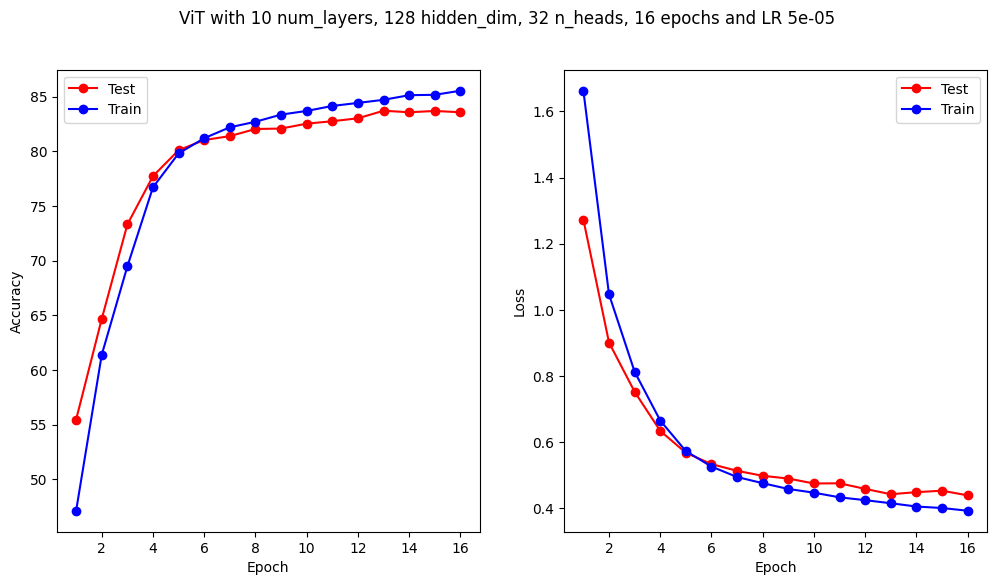

In [25]:
# Define ViT parameters
param_dict = dict(
    num_layers=10,
    num_heads=32,
    num_classes=10,
    hidden_dim=128,
    mlp_dim=128,
    dropout=0.1,
    patch_size=4,
    image_size=train_dataset[0][0].shape[1],
    N_EPOCHS=16,
    LR=5e-5,
)


model_3 = model_from_params(**param_dict)

## Print classification results for best model

Define function that estimates classification results for a given number of images of the dataset and a model

In [61]:
import random

CLASSES = ['T-shirt/top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

def estimate_results(model, image_num=10):
    used_idxs = []
    for _ in range(image_num):
        # Select randomly between test/train dataset
        datasets = [train_dataset, test_dataset]
        dataset = next(iter(random.sample(datasets, 1)))
        dataset_length = len(dataset)

        # Select a random image index in the dataset
        index = next(x for x in range(dataset_length) if x not in used_idxs)
        used_idxs.append(index)

        # Estimate classification results for a given dataset image
        image, label = dataset[index]

        plt.axis("off")
        plt.imshow(image.transpose(0, 2).transpose(0, 1))
        plt.show()

        prediction = model(image.unsqueeze(0).to(device))
        title(f"Model predicted class '{CLASSES[torch.argmax(prediction).item()]}'. GT class is '{CLASSES[label]}'.")
        print(f"Probability vector: {prediction}")
        print()

The best model is `model_3` so we pass it to the estimation function and print results

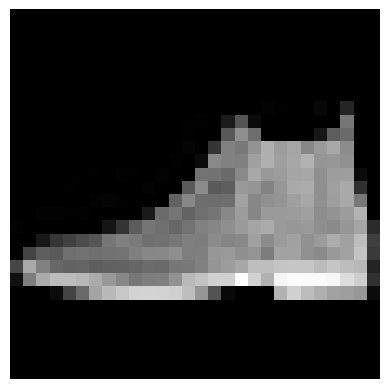

================== Model predicted class 'ankle boot'. GT class is 'ankle boot'. ===================


Probability vector: tensor([[-1.9677, -1.5872, -2.3763, -1.7236, -1.0909,  2.3145, -4.0103,  4.0387,
         -0.4179,  6.4311]], device='cuda:0', grad_fn=<AddmmBackward0>)



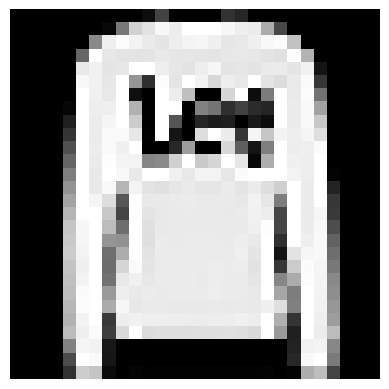

==================== Model predicted class 'pullover'. GT class is 'pullover'. =====================


Probability vector: tensor([[ 0.6983, -2.8333,  5.5855, -0.9029,  3.2659, -2.5692,  4.0544, -4.1633,
         -0.6755, -3.5457]], device='cuda:0', grad_fn=<AddmmBackward0>)



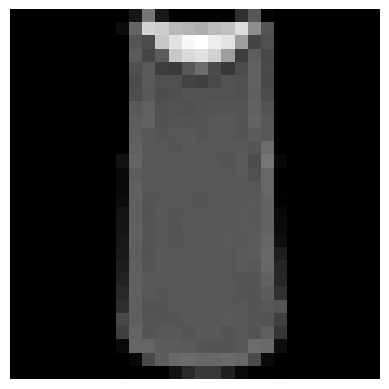

================= Model predicted class 'T-shirt/top'. GT class is 'T-shirt/top'. ==================


Probability vector: tensor([[ 5.0123, -0.4977, -0.6848,  3.7139,  0.3335, -3.4380,  3.9988, -4.1266,
         -0.7928, -3.8978]], device='cuda:0', grad_fn=<AddmmBackward0>)



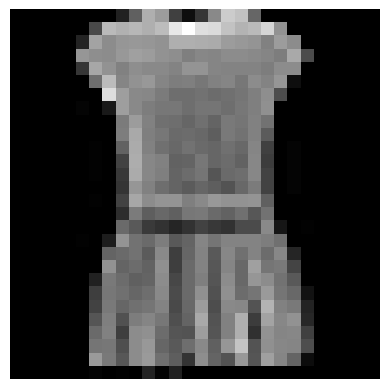

======================= Model predicted class 'dress'. GT class is 'dress'. ========================


Probability vector: tensor([[ 3.1395, -0.8192, -0.6106,  5.0864,  0.9556, -2.0887,  3.1983, -5.0162,
         -0.6395, -3.1934]], device='cuda:0', grad_fn=<AddmmBackward0>)



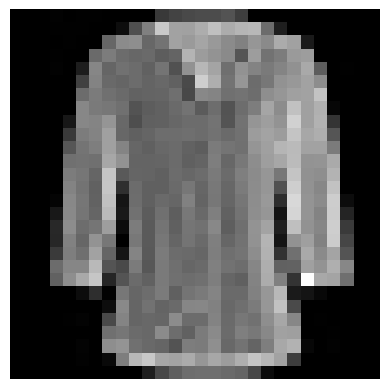

======================= Model predicted class 'shirt'. GT class is 'shirt'. ========================


Probability vector: tensor([[ 3.8402, -1.6901,  3.0298,  1.6536,  1.4028, -2.9765,  4.9971, -5.4329,
         -0.9984, -4.5288]], device='cuda:0', grad_fn=<AddmmBackward0>)



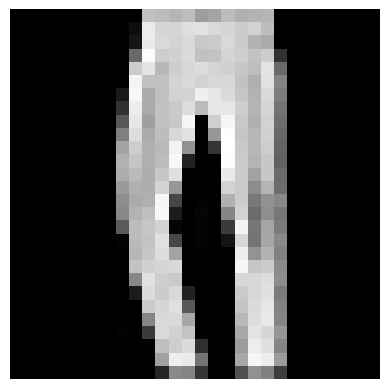

===================== Model predicted class 'trouser'. GT class is 'trouser'. ======================


Probability vector: tensor([[-0.7276,  7.8369,  0.0856,  0.7274, -0.9984, -0.3752, -1.1948, -1.3290,
         -0.3579, -0.5961]], device='cuda:0', grad_fn=<AddmmBackward0>)



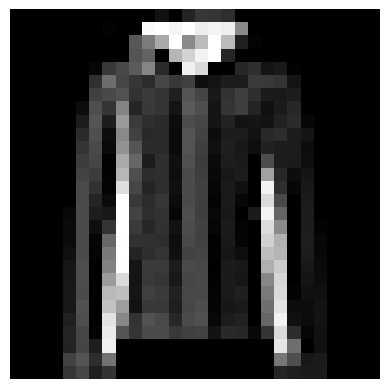

======================== Model predicted class 'coat'. GT class is 'coat'. =========================


Probability vector: tensor([[-0.5696, -2.2822,  4.7852,  0.8119,  4.8305, -2.6328,  3.0936, -3.7417,
         -1.7077, -3.3576]], device='cuda:0', grad_fn=<AddmmBackward0>)



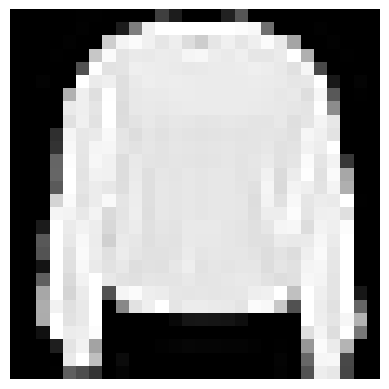

==================== Model predicted class 'pullover'. GT class is 'pullover'. =====================


Probability vector: tensor([[ 0.9870, -2.8437,  5.2133, -1.3552,  3.8942, -3.7612,  4.4089, -4.8475,
          0.1630, -3.1125]], device='cuda:0', grad_fn=<AddmmBackward0>)



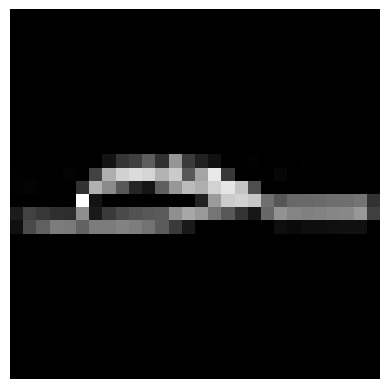

====================== Model predicted class 'sandal'. GT class is 'sandal'. =======================


Probability vector: tensor([[-1.1576, -0.4023, -0.6670, -1.0695, -3.2444,  6.1969, -1.6014,  1.6173,
          2.2406, -1.9007]], device='cuda:0', grad_fn=<AddmmBackward0>)



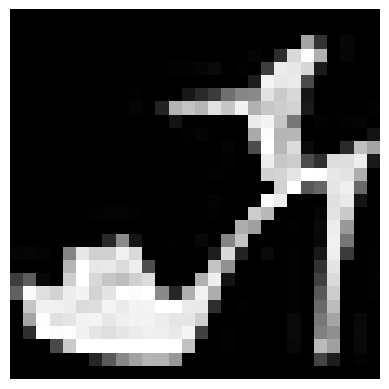

====================== Model predicted class 'sandal'. GT class is 'sandal'. =======================


Probability vector: tensor([[-0.1513, -0.3884, -0.4562, -0.4456, -3.2119,  7.2538, -1.8778, -0.1935,
         -0.0452,  0.3813]], device='cuda:0', grad_fn=<AddmmBackward0>)



In [62]:
estimate_results(model_3)